In [5]:
notebook_id = "151"

<a id="ID_top"></a>
## Adjacency matrix and network chart

This workflow takes live files and calls on functions in `script_adj_matrix_plot.py` to create adjancency matrices and network graph

#### Notebook sections:
    
|| [0|Top](#ID_top) || [1|Part1](#ID_part1) || [2|Part2](#ID_part2) || [3|Part3](#ID_part3) || [4|Part4](#ID_part4) || [5|Part5](#ID_part5) ||

### Packages

In [6]:
# %load s_package_import
# package library, use to ensure consistency across notebooks, refresh periodically
# general packages
import os # use with os.listdir(_path_)
import requests
import csv
import time
from datetime import datetime
from shutil import copyfile

#temp check
#from shutil import make_archive
import zipfile

# data analysis packages
import pandas as pd
pd.options.display.max_columns = None # don't truncate columns
#pd.options.display.max_rows = None

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes
import pycountry

# custom scripts
import s_file_export
import s_filepaths
import s_un_comtrade_extract as s_un
import s_adj_matrix_plot

#=== network analysis
import networkx as nx
#=== gavity modelling
import gme as gme

#### Import module and declare path variables
`import s_filepaths.py`

In [7]:
# import ref file
import s_filepaths

# declare local variables to work with
path_raw = s_filepaths.path_raw
path_raw_dl = s_filepaths.path_raw_dl
path_store = s_filepaths.path_store
path_live = s_filepaths.path_live
path_image = s_filepaths.path_images

<a id="ID_part2"></a>
### Part 2 | Load files
|| [0|Top](#ID_top) || [1|Part1](#ID_part1) || [2|Part2](#ID_part2) || [3|Part3](#ID_part3) || [4|Part4](#ID_part4) || [5|Part5](#ID_part5) ||

In [8]:
filenames = os.listdir(path_live)
print(filenames)

['input_101_master_country_table.csv.csv.gzip', 'input_test.csv.gzip', 'input_un_com_2013.csv.gzip', 'input_un_com_2012.csv.gzip', 'input_un_com_2006-2009.csv.gzip', '.DS_Store', 'input_101_master_country_table.csv.gzip', 'input_un_codes_ref.csv.gzip', 'input_bri_countries_manual_2020.csv.gzip', 'input_un_com_2016-2019.csv.gzip', 'input_un_com_2002-2005.csv.gzip', 'input_un_com_2014.csv.gzip', 'input_un_com_2015.csv.gzip', 'input_bri_countries_Dumor_Yao.csv.gzip', '2_raw_explainer_doc.md', 'input_dynamic_gravity.csv.gzip', 'input_un_com_2010_merged_ref.csv.gzip', 'input_gme_data_joined.csv.gzip', 'input_un_sample.csv.gzip']


In [10]:
# Load master country list
file_name = "input_101_master_country_table.csv.gzip"
df_country = pd.read_csv(f"{path_live}{file_name}",compression= "gzip")
df_country.head()

iso_3   country_name        lat       long  bri_year  bri_data  un_code  \
0   ABW          Aruba  12.530384 -70.028992       NaN       NaN    533.0   
1   AFG    Afghanistan  34.649338  67.113739    2016.0       1.0      4.0   
2   AGO         Angola -11.704597  16.376490    2018.0       1.0     24.0   
3   AIA       Anguilla  18.217348 -63.057232       NaN       NaN    660.0   
4   ALA  Aland Islands  60.096996  19.949005       NaN       NaN      NaN   

   un_flag  
0      1.0  
1      1.0  
2      1.0  
3      1.0  
4      NaN

In [11]:
# Load in master UN and gravity dataset with contiguity
file_name = "input_gme_data_joined.csv.gzip"
df_un_grav = pd.read_csv(f"{path_live}{file_name}",compression= "gzip")
df_un_grav.head()

year    country_o iso3_o    country_d iso3_d    distance  gdp_wdi_const_o  \
0  2009  Philippines    PHL        Aruba    ABW  16904.5960     1.854377e+11   
1  2009  Philippines    PHL        Aruba    ABW  16904.5960     1.854377e+11   
2  2009      Romania    ROU  Afghanistan    AFG   1883.9504     1.693503e+11   
3  2009      Romania    ROU  Afghanistan    AFG   1883.9504     1.693503e+11   
4  2010      Denmark    DNK  Afghanistan    AFG   4835.0132     3.219939e+11   

   gdp_wdi_const_d  common_language  contiguity  agree_pta_goods  agree_cu  \
0              NaN                1           0                0         0   
1              NaN                1           0                0         0   
2     1.469733e+10                0           0                0         0   
3     1.469733e+10                0           0                0         0   
4     1.593680e+10                0           0                0         0   

   sanction_imposition  rtCode rt3ISO      rtTitle  ptCode pt3ISO  \
0                  0.0     608    PHL  Philippines     533    ABW   
1                  0.0     608    PHL  Philippines     533    ABW   
2                  0.0     642    ROU      Romania       4    AFG   
3                  0.0     642    ROU      Romania       4    AFG   
4                  0.0     208    DNK      Denmark       4    AFG   

       ptTitle  period  rgDesc    yr  rgCode cmdCode  TradeValue  periodDesc  \
0        Aruba    2009  Import  2009       1   TOTAL       72162        2009   
1        Aruba    2009  Export  2009       2   TOTAL      149587        2009   
2  Afghanistan    2009  Import  2009       1   TOTAL        1688        2009   
3  Afghanistan    2009  Export  2009       2   TOTAL    15843818        2009   
4  Afghanistan    2010  Import  2010       1   TOTAL     5267969        2010   

  pfCode         cmdDescE  
0     H2  ALL COMMODITIES  
1     H2  ALL COMMODITIES  
2     H3  All Commodities  
3     H3  All Commodities  
4     H3  All Commodities

In [12]:
# Global dataset by contiguity
df_network_vis = df_un_grav.copy()
df_network_vis = df_network_vis[(df_network_vis.contiguity == 1) & (df_network_vis.year == 2010) & (df_network_vis.rgDesc == "Export")]
df_network_vis.head()

year country_o iso3_o    country_d iso3_d    distance  gdp_wdi_const_o  \
486   2010  Slovenia    SVN      Hungary    HUN   370.63492     4.801647e+10   
603   2010    Israel    ISR      Lebanon    LBN   211.13699     2.337547e+11   
2824  2010  Pakistan    PAK  Afghanistan    AFG   774.05566     1.774069e+11   
2839  2010     China    CHN  Afghanistan    AFG  4353.06490     6.100620e+12   
2960  2010      Iran    IRN  Afghanistan    AFG  1495.72110     4.677902e+11   

      gdp_wdi_const_d  common_language  contiguity  agree_pta_goods  agree_cu  \
486      1.302582e+11                1           1                1         1   
603      3.800995e+10                1           1                0         0   
2824     1.593680e+10                1           1                0         0   
2839     1.593680e+10                0           1                0         0   
2960     1.593680e+10                1           1                0         0   

      sanction_imposition  rtCode rt3ISO   rtTitle  ptCode pt3ISO  \
486                   0.0     705    SVN  Slovenia     348    HUN   
603                   0.0     376    ISR    Israel     422    LBN   
2824                  0.0     586    PAK  Pakistan       4    AFG   
2839                  0.0     156    CHN     China       4    AFG   
2960                  0.0     364    IRN      Iran       4    AFG   

          ptTitle  period  rgDesc    yr  rgCode cmdCode  TradeValue  \
486       Hungary    2010  Export  2010       2   TOTAL   719092694   
603       Lebanon    2010  Export  2010       2   TOTAL        3000   
2824  Afghanistan    2010  Export  2010       2   TOTAL  1684665983   
2839  Afghanistan    2010  Export  2010       2   TOTAL   175264609   
2960  Afghanistan    2010  Export  2010       2   TOTAL  1315721611   

      periodDesc pfCode         cmdDescE  
486         2010     H3  All Commodities  
603         2010     H3  All Commodities  
2824        2010     H3  All Commodities  
2839        2010     H3  All Commodities  
2960        2010     H2  ALL COMMODITIES

In [13]:
# load gravity dataset
file_name = "input_dynamic_gravity.csv.gzip"
df_grav_2 = pd.read_csv(f"{path_live}{file_name}",compression="gzip")
df_grav_2.head()

Unnamed: 0  year country_d iso3_d dynamic_code_d  landlocked_d  island_d  \
0           0  2005     Aruba    ABW            ABW             0         1   
1           1  2006     Aruba    ABW            ABW             0         1   
2           2  2007     Aruba    ABW            ABW             0         1   
3           3  2008     Aruba    ABW            ABW             0         1   
4           4  2009     Aruba    ABW            ABW             0         1   

    region_d  gdp_pwt_const_d     pop_d  gdp_pwt_cur_d  capital_cur_d  \
0  caribbean        3906.5203  0.100031      4093.2434      23531.377   
1  caribbean        4118.1396  0.100830      4217.0669      25757.818   
2  caribbean        4196.4634  0.101218      4248.4707      27375.447   
3  caribbean        4433.6772  0.101342      4441.8828      28639.586   
4  caribbean        4183.0449  0.101416      4304.9224      29400.539   

   capital_const_d  gdp_wdi_cur_d  gdp_wdi_const_d  gdp_wdi_cap_cur_d  \
0        24173.982   2.331006e+09              NaN       23302.831988   
1        25396.307   2.421475e+09              NaN       24015.420612   
2        26631.465   2.623726e+09              NaN       25921.538234   
3        27871.596   2.791961e+09              NaN       27549.889422   
4        29122.635   2.498933e+09              NaN       24640.421244   

   gdp_wdi_cap_const_d      lat_d      lng_d  polity_d  polity_abs_d  \
0                  NaN  12.530384 -70.028992       NaN           NaN   
1                  NaN  12.530384 -70.028992       NaN           NaN   
2                  NaN  12.530384 -70.028992       NaN           NaN   
3                  NaN  12.530384 -70.028992       NaN           NaN   
4                  NaN  12.530384 -70.028992       NaN           NaN   

               country_o iso3_o dynamic_code_o  landlocked_o  island_o  \
0   Netherlands Antilles    ANT          ANT.X             0         0   
1               Anguilla    AIA            AIA             0         1   
2  Sao Tome and Principe    STP            STP             0         1   
3                Andorra    AND            AND             1         0   
4            Philippines    PHL            PHL             0         1   

          region_o  gdp_pwt_const_o      pop_o  gdp_pwt_cur_o  capital_cur_o  \
0        caribbean              NaN        NaN            NaN            NaN   
1        caribbean        348.76880   0.012903      365.93643   2.471682e+03   
2           africa        391.01483   0.160064      392.44177   1.101736e+03   
3           europe              NaN        NaN            NaN            NaN   
4  south_east_asia     458079.81000  91.641881   460142.72000   1.420047e+06   

   capital_const_o  gdp_wdi_cur_o  gdp_wdi_const_o  gdp_wdi_cap_cur_o  \
0              NaN            NaN              NaN                NaN   
1     2.342796e+03            NaN              NaN                NaN   
2     3.205526e+03   1.458274e+08     1.670446e+08         911.057012   
3              NaN   4.001201e+09     3.675947e+09       46734.268282   
4     1.624159e+06   1.683346e+11     1.854377e+11        1836.874120   

   gdp_wdi_cap_const_o      lat_o       lng_o  polity_o  polity_abs_o  \
0                  NaN  12.250778  -69.301224       NaN           NaN   
1                  NaN  18.217348  -63.057232       NaN           NaN   
2          1043.611485   0.989202    7.072665       NaN           NaN   
3         42935.277871  42.500000    1.516486       NaN           NaN   
4          2023.503659  11.817977  122.775020       8.0           8.0   

   contiguity  agree_pta_goods  agree_pta_services  agree_cu  agree_eia  \
0           0                1                   0         0          0   
1           0                1                   0         0          0   
2           0                0                   0         0          0   
3           0                0                   0         0          0   
4           0                0        

In [14]:
len(df_grav_2)

746048

**Adjecency matrix**

In [15]:
# variable to save adj. matrix | based on origin and destination iso_3 codes
data_network = s_adj_matrix_plot.f_adj_matrix(df_grav_2,"iso3_o","iso3_d",
                                            p_col_full = "country_o",p_index_full = "country_d")

matrix_adj = data_network[0] # adjecency matrix
data_pairs = data_network[1] # list of country pairs

Start-up report | Two different equal count (253) columns are used.


**Build network**

nodes: 253
edges: 343


/Users/antonios/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


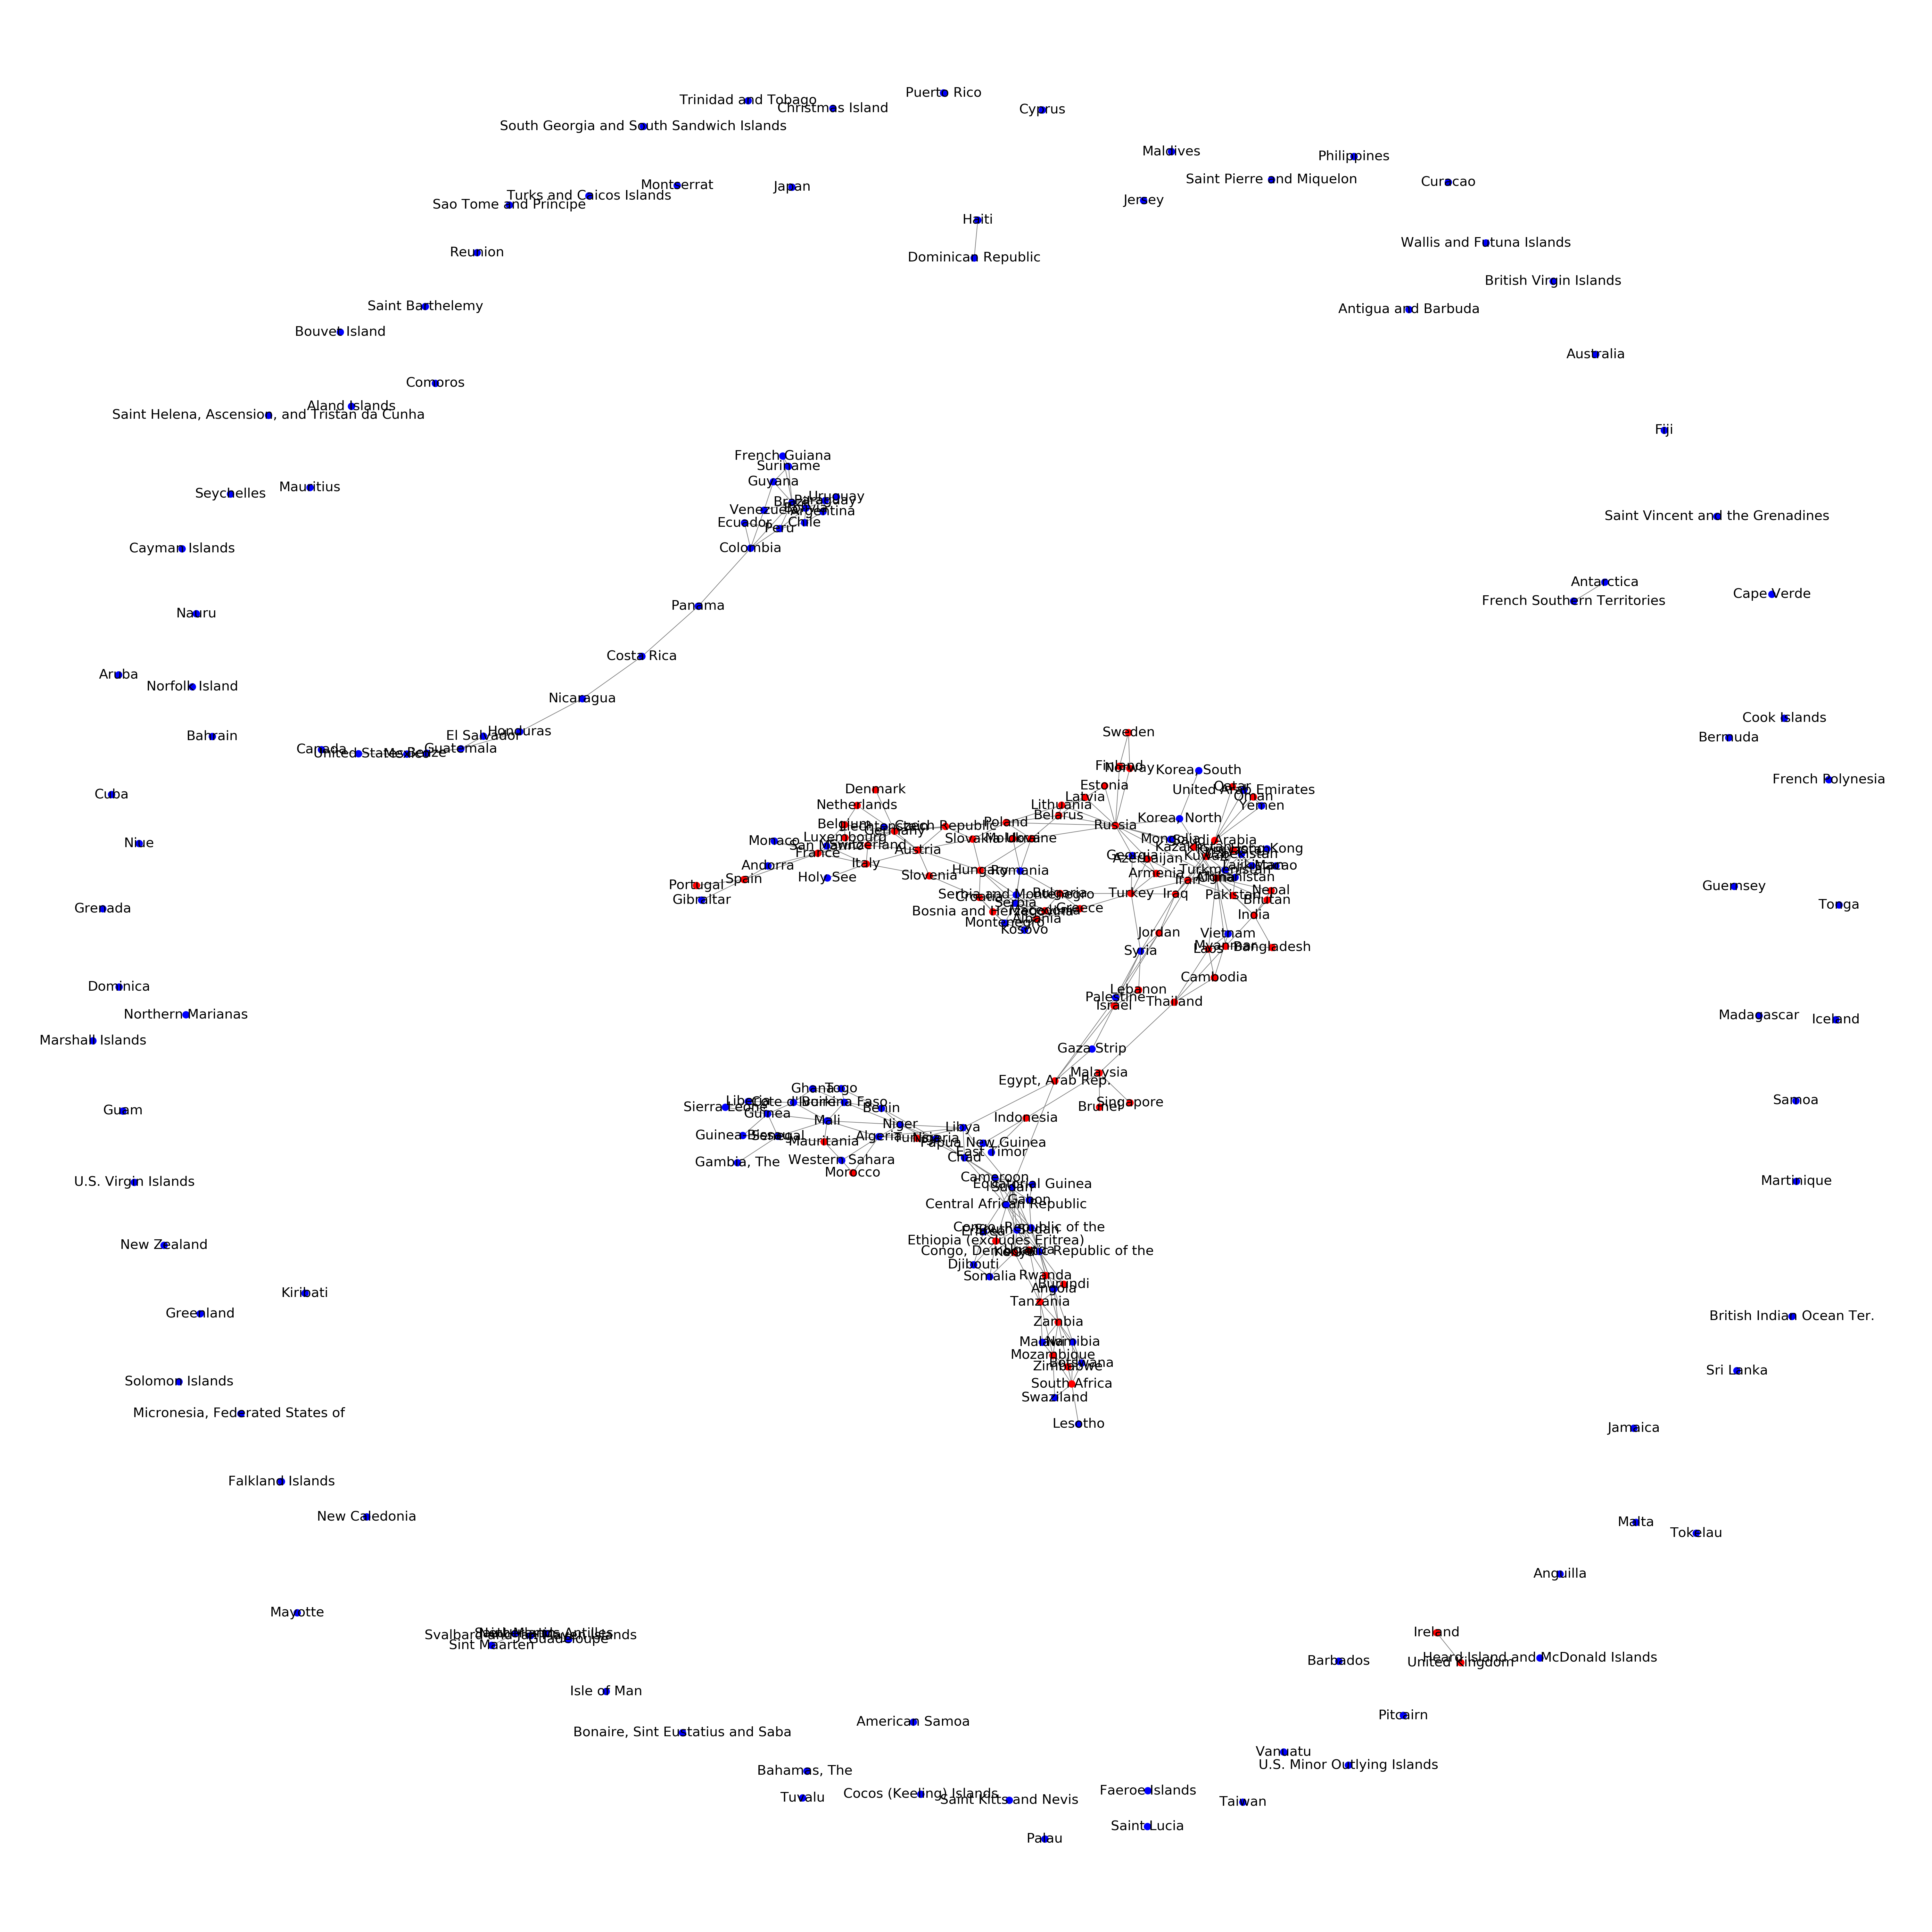

In [16]:
graph_object = s_adj_matrix_plot.f_graph(data_pairs,
                    p_group_of_countries = list(df_network_vis.country_o.unique()),
                    p_edge_colour="grey",p_colour_group="red",p_seed = 1, p_weight = "distance"                     
                    )

# add positional argument to function

**Visualise**

Use: "https://plotly.com/python/network-graphs/"

In [3]:
import plotly.graph_objects as go

In [30]:
for edge in graph_object.edges():
    print(edge[0])
    print(G.nodes[edge[0]])

Afghanistan
{}
Afghanistan
{}
Afghanistan
{}
Afghanistan
{}
Afghanistan
{}
Afghanistan
{}
China
{}
China
{}
China
{}
China
{}
China
{}
China
{}
China
{}
China
{}
China
{}
China
{}
China
{}
China
{}
China
{}
China
{}
China
{}
Iran
{}
Iran
{}
Iran
{}
Iran
{}
Iran
{}
Iran
{}
Pakistan
{}
Tajikistan
{}
Tajikistan
{}
Tajikistan
{}
Turkmenistan
{}
Turkmenistan
{}
Turkmenistan
{}
Uzbekistan
{}
Uzbekistan
{}
Angola
{}
Angola
{}
Angola
{}
Angola
{}
Congo, Democratic Republic of the 
{}
Congo, Democratic Republic of the 
{}
Congo, Democratic Republic of the 
{}
Congo, Democratic Republic of the 
{}
Congo, Democratic Republic of the 
{}
Congo, Democratic Republic of the 
{}
Congo, Democratic Republic of the 
{}
Congo, Democratic Republic of the 
{}
Congo, Republic of the 
{}
Congo, Republic of the 
{}
Congo, Republic of the 
{}
Namibia
{}
Namibia
{}
Namibia
{}
Zambia
{}
Zambia
{}
Zambia
{}
Zambia
{}
Zambia
{}
Albania
{}
Albania
{}
Albania
{}
Albania
{}
Albania
{}
Albania
{}
Greece
{}
Greece
{}
Gre

In [20]:
G = graph_object.copy()

In [18]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

KeyError: 'pos'

**Analyse network**

In [ ]:
dict_centrality = nx.degree_centrality(graph_object)

In [ ]:
# Testing the network for CENTRALITY
df_centrality = pd.DataFrame.from_dict(dict_centrality,orient='index',columns=["centrality_score"])
df_centrality.sort_values(by = "centrality_score",ascending = False).head()

In [ ]:
# This can tell us if a network has bridges
nx.has_bridges(graph_object)

In [ ]:
# Identify all bridges in the network
list(nx.bridges(graph_object))

****

In [ ]:
# list of all files
filenames = os.listdir(path_live)
print(filenames)

# list of file names that can be read with same rule
file_to_batch_read = "input_gme_data_joined.csv.gzip"

Load data directly from compressed file to avoid GitHub issues with storage

In [ ]:
# Load data
network_df_raw = pd.read_csv(f"{path_live}{file_to_batch_read}",compression= "gzip")
network_df_raw.head()

### Prepare data for visualisation

In [ ]:
# only neighbouring countries

#network_df_vis = network_df_raw[network_df_raw.year == 2016]
network_df_vis = network_df_raw.copy()
network_df_vis = network_df_vis[(network_df_vis.contiguity == 1) & (network_df_vis.year == 2010) & (network_df_vis.rgDesc == "Export")]
#network_df_vis = network_df_vis[(network_df_vis.contiguity == 1)]

network_df_vis.head()

In [ ]:
#temp_df test df working
test_f_run = s_adj_matrix_plot.f_adj_matrix(network_df_vis,"iso3_o","iso3_d",p_col_full = "country_o",p_index_full = "country_d")


In [ ]:
graph_object = s_adj_matrix_plot.f_graph(test_f_run[1],p_group_of_countries = list(network_df_vis.country_o.unique()),
                          p_edge_colour="grey",p_colour_group="red",p_seed = 1, p_weight = "distance"                     
                         )

In [ ]:
plt.figure(1,figsize = (40,40),dpi = 150)
nx.spectral_layout(graph_object,edge_color = "grey",
               node_size=100,font_size=20,seed = 1,weight="distance")#,with_labels = True, font_weight = "light")
plt.show()

In [ ]:
plt.figure(1,figsize = (40,40),dpi = 150)

pos = nx.draw_kamada_kawai(graph_object, weight = "distance")
nx.draw(graph_object,pos = pos)#,with_labels = True, font_weight = "light")
plt.show()

In [ ]:
break

In [ ]:
def f_graph(p_tuples,p_group_of_countries = None,p_colour_group = "yellow", p_colour_default = "blue", p_edge_colour = "red"):

    """This function takes in the list of tuples from f_adj_matrix() (should be at index [1])
    Plus list of countries (full name, i.e. country_o or country_d columns) for colournig, else defaults to blue nodes"""
    import networkx as nx

    #=== Set up network
    f_G = nx.Graph()

    # Add nodes based on full country names
    #f_G.add_nodes_from(p_uniques)

    #=== base for checking nodes and edges
    def f_add_node_and_edge(p_graph,p_central_node,p_node_list,p_length = 5):
        # list of edges
        temp_edges = []
        # list of neighbours
        p_node_list

        try:
            p_graph.add_node(p_central_node)
        except:
            pass

        for country in p_node_list:
            temp_tuple = (p_central_node,country)
            temp_edges.append(temp_tuple)

        p_graph.add_edges_from(temp_edges,length = p_length)

    #=== run function to add values
    for entry in p_tuples:
        f_add_node_and_edge(f_G,entry[0],entry[1])

    #=== node colouring | compare list of countries to be treated differently to list of nodes
    colour_list = []


    for entry in list(f_G.nodes):
        if entry in p_group_of_countries:
            colour_list.append(p_colour_group)
        else:
            colour_list.append(p_colour_default)
    #except:
     #   print("Colouring didn't work, defaulting to {p_col_default}")
      #  colour_list = p_colour_default

    #=== report
    print("nodes:",f_G.number_of_nodes())
    print("edges:",f_G.number_of_edges())


In [ ]:
f_G_out = f_graph(test_f_run[1],p_group_of_countries = list(network_df_vis.country_o.unique()))

In [ ]:
len(test_f_run[1])

In [ ]:
break

#### Filter on certain countries

Filter for all of asia:
```
trial_df = trial_df[
    ((trial_df.region_d.str.contains("asia")) | (trial_df.region_d.str.contains("east")))
    & 
    ((trial_df.region_o.str.contains("asia")) | (trial_df.region_o.str.contains("east")))
```

Filter for all countries that have a connection (avoid showing little islands or unconnected regions
```
trial_df = trial_df[(trial_df.contiguity == 1)]
```

In [ ]:
# Filters
europe_filter = (trial_df.region_d == "europe") & (trial_df.region_o == "europe")
europe_land_filter = (trial_df.region_d == "europe") & (trial_df.region_o == "europe") & (trial_df.contiguity == 1)
asia_all = ((trial_df.region_d.str.contains("asia")) | (trial_df.region_d.str.contains("east"))) & ((trial_df.region_o.str.contains("asia")) | (trial_df.region_o.str.contains("east")))
land_all = (trial_df.contiguity == 1)

#trial_df = trial_df[(trial_df.region_d == "europe") & (trial_df.region_o == "europe") & (trial_df.contiguity == 1)]

In [ ]:
# Preview data
trial_df = df_05_16[df_05_16.year == 2016]
trial_df = trial_df[(trial_df.region_d == "europe") & (trial_df.region_o == "europe") & (trial_df.contiguity == 1)]

trial_df.head()

<a id="ID_part3"></a>
### Part 3 | Produce matrix and network
|| [0|Top](#ID_top) || [1|Part1](#ID_part1) || [2|Part2](#ID_part2) || [3|Part3](#ID_part3) || [4|Part4](#ID_part4) || [5|Part5](#ID_part5) ||

In [ ]:
#temp_df test df working
test_f_run = mp.f_adj_matrix(trial_df,"iso3_o","iso3_d",p_col_full = "country_o",p_index_full = "country_d")
mp.f_graph(test_f_run[1])